In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score,
    roc_curve,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# Loading the final features (scaled manual + TF-IDF)
df = pd.read_csv(r"D:\AutoJudge_v2\data\features_final.csv")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.shape[1]}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (4999, 518)
Columns: 518

First few rows:


,char_count,word_count,sentence_count,avg_word_length,uppercase_count,digit_count,math_symbol_count,equation_count,bracket_count,dollar_sign_count,...,xor,y_i,year,yes,yes yes,yi,zero,problem_class,problem_class_encoded,problem_score
0,0.117736,0.353938,0.944483,-1.077678,0.650655,0.385807,0.520830,-0.912440,-0.677247,-0.912438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hard,1,7.95
1,-0.053850,0.073278,-0.415126,-0.665172,0.650655,-0.021200,-0.363795,-0.787533,-0.403231,-0.787534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hard,1,5.91
2,-0.011829,0.253702,0.264678,-1.267560,2.071754,1.231130,3.528557,-0.849986,0.144801,-0.849986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hard,1,6.32
3,0.554288,0.855117,-0.415126,-1.127976,1.525178,-0.021200,0.166980,-0.912440,-0.494569,-0.912438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hard,1,6.32
4,0.680352,1.068954,0.604580,-1.363899,1.197232,0.166650,-0.186870,-0.912440,-0.585908,-0.912438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hard,1,6.32


***Preparing Data for Classification***

In [4]:
# Separating features and target
X = df.drop(['problem_class', 'problem_class_encoded', 'problem_score'], axis=1)
y = df['problem_class_encoded']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

Features (X) shape: (4999, 515)
Target (y) shape: (4999,)


In [5]:
# Loading label encoder to get class names
with open(r"D:\AutoJudge_v2\models\label_encoder.pkl", 'rb') as f:
    label_encoder = pickle.load(f)

class_names = label_encoder.classes_
print(f"\nClass names: {class_names}")


Class names: ['easy' 'hard' 'medium']


In [6]:
# Class distribution
print("\n" + "="*70)
print("CLASS DISTRIBUTION")
print("="*70)

class_dist = df['problem_class'].value_counts()
print("\nAbsolute counts:")
print(class_dist)

print("\nPercentages:")
print(df['problem_class'].value_counts(normalize=True) * 100)


CLASS DISTRIBUTION

Absolute counts:
problem_class
hard      2577
medium    1434
easy       988
Name: count, dtype: int64

Percentages:
problem_class
hard      51.550310
medium    28.685737
easy      19.763953
Name: proportion, dtype: float64


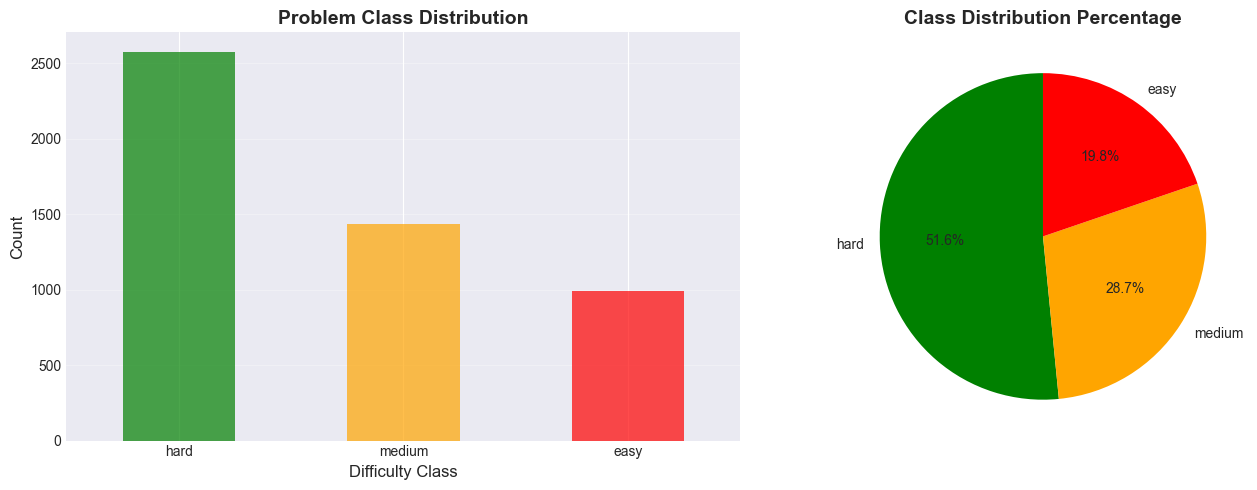

In [7]:
# Visualizing class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_dist.plot(kind='bar', ax=axes[0], color=['green', 'orange', 'red'], alpha=0.7)
axes[0].set_title('Problem Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Difficulty Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
colors = ['green', 'orange', 'red']
axes[1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title('Class Distribution Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

***Train-Test Split***

In [8]:
# Splitting with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Split ratio: 80:20 (train:test)")

print("\nTraining set class distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_dist.items():
    print(f"  {label_encoder.inverse_transform([idx])[0]}: {count} ({count/len(y_train)*100:.1f}%)")

print("\nTest set class distribution:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for idx, count in test_dist.items():
    print(f"  {label_encoder.inverse_transform([idx])[0]}: {count} ({count/len(y_test)*100:.1f}%)")

Training set size: (3999, 515)
Test set size: (1000, 515)
Split ratio: 80:20 (train:test)

Training set class distribution:
  easy: 790 (19.8%)
  hard: 2062 (51.6%)
  medium: 1147 (28.7%)

Test set class distribution:
  easy: 198 (19.8%)
  hard: 515 (51.5%)
  medium: 287 (28.7%)


***Model Training***

In [ ]:
# Defining models to train
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=42,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        class_weight='balanced'
    ),
    'SVM': SVC(
        kernel='rbf', 
        random_state=42,
        probability=True,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, 
        random_state=42
    )
    #'XGB Classifier' : XGBClassifier(
        #eval_metric="mlogloss",
        #tree_method="hist"
    #)
}

In [10]:
# Storing results
results = {}

# Training and evaluating each model
for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print('='*60)
    
    # Training
    print("Fitting model...")
    model.fit(X_train, y_train)
    print("✓ Training complete!")
    
    # Predictions
    print("Making predictions...")
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculating metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    precision = precision_score(y_test, y_pred_test, average='weighted')
    recall = recall_score(y_test, y_pred_test, average='weighted')
    f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    # Cross-validation score
    print("Performing 5-fold cross-validation...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
    
    # Storing results
    results[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred_test
    }
    
    # Print results
    print(f"\nResults:")
    print(f"  Train Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy:  {test_accuracy:.4f}")
    print(f"  Precision:      {precision:.4f}")
    print(f"  Recall:         {recall:.4f}")
    print(f"  F1-Score:       {f1:.4f}")
    print(f"  CV Score:       {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")



Training: Logistic Regression
Fitting model...
✓ Training complete!
Making predictions...
Performing 5-fold cross-validation...

Results:
  Train Accuracy: 0.7019
  Test Accuracy:  0.6080
  Precision:      0.6112
  Recall:         0.6080
  F1-Score:       0.6054
  CV Score:       0.6028 (±0.0259)

Training: Random Forest
Fitting model...
✓ Training complete!
Making predictions...
Performing 5-fold cross-validation...

Results:
  Train Accuracy: 1.0000
  Test Accuracy:  0.6490
  Precision:      0.6228
  Recall:         0.6490
  F1-Score:       0.6193
  CV Score:       0.6316 (±0.0101)

Training: SVM
Fitting model...
✓ Training complete!
Making predictions...
Performing 5-fold cross-validation...

Results:
  Train Accuracy: 0.6464
  Test Accuracy:  0.5350
  Precision:      0.5733
  Recall:         0.5350
  F1-Score:       0.5428
  CV Score:       0.5366 (±0.0264)

Training: Gradient Boosting
Fitting model...
✓ Training complete!
Making predictions...
Performing 5-fold cross-validation..

***Model Comparison***

In [11]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Acc': [r['train_accuracy'] for r in results.values()],
    'Test Acc': [r['test_accuracy'] for r in results.values()],
    'Precision': [r['precision'] for r in results.values()],
    'Recall': [r['recall'] for r in results.values()],
    'F1-Score': [r['f1'] for r in results.values()],
    'CV Mean': [r['cv_mean'] for r in results.values()],
    'CV Std': [r['cv_std'] for r in results.values()]
})

# Round for display
comparison_display = comparison_df.copy()
comparison_display.iloc[:, 1:] = comparison_display.iloc[:, 1:].round(4)

print("\n", comparison_display.to_string(index=False))


               Model  Train Acc  Test Acc  Precision  Recall  F1-Score  CV Mean  CV Std
Logistic Regression     0.7019     0.608     0.6112   0.608    0.6054   0.6028  0.0259
      Random Forest     1.0000     0.649     0.6228   0.649    0.6193   0.6316  0.0101
                SVM     0.6464     0.535     0.5733   0.535    0.5428   0.5366  0.0264
  Gradient Boosting     0.8112     0.666     0.6449   0.666    0.6444   0.6374  0.0120


***Visualizing comparison***

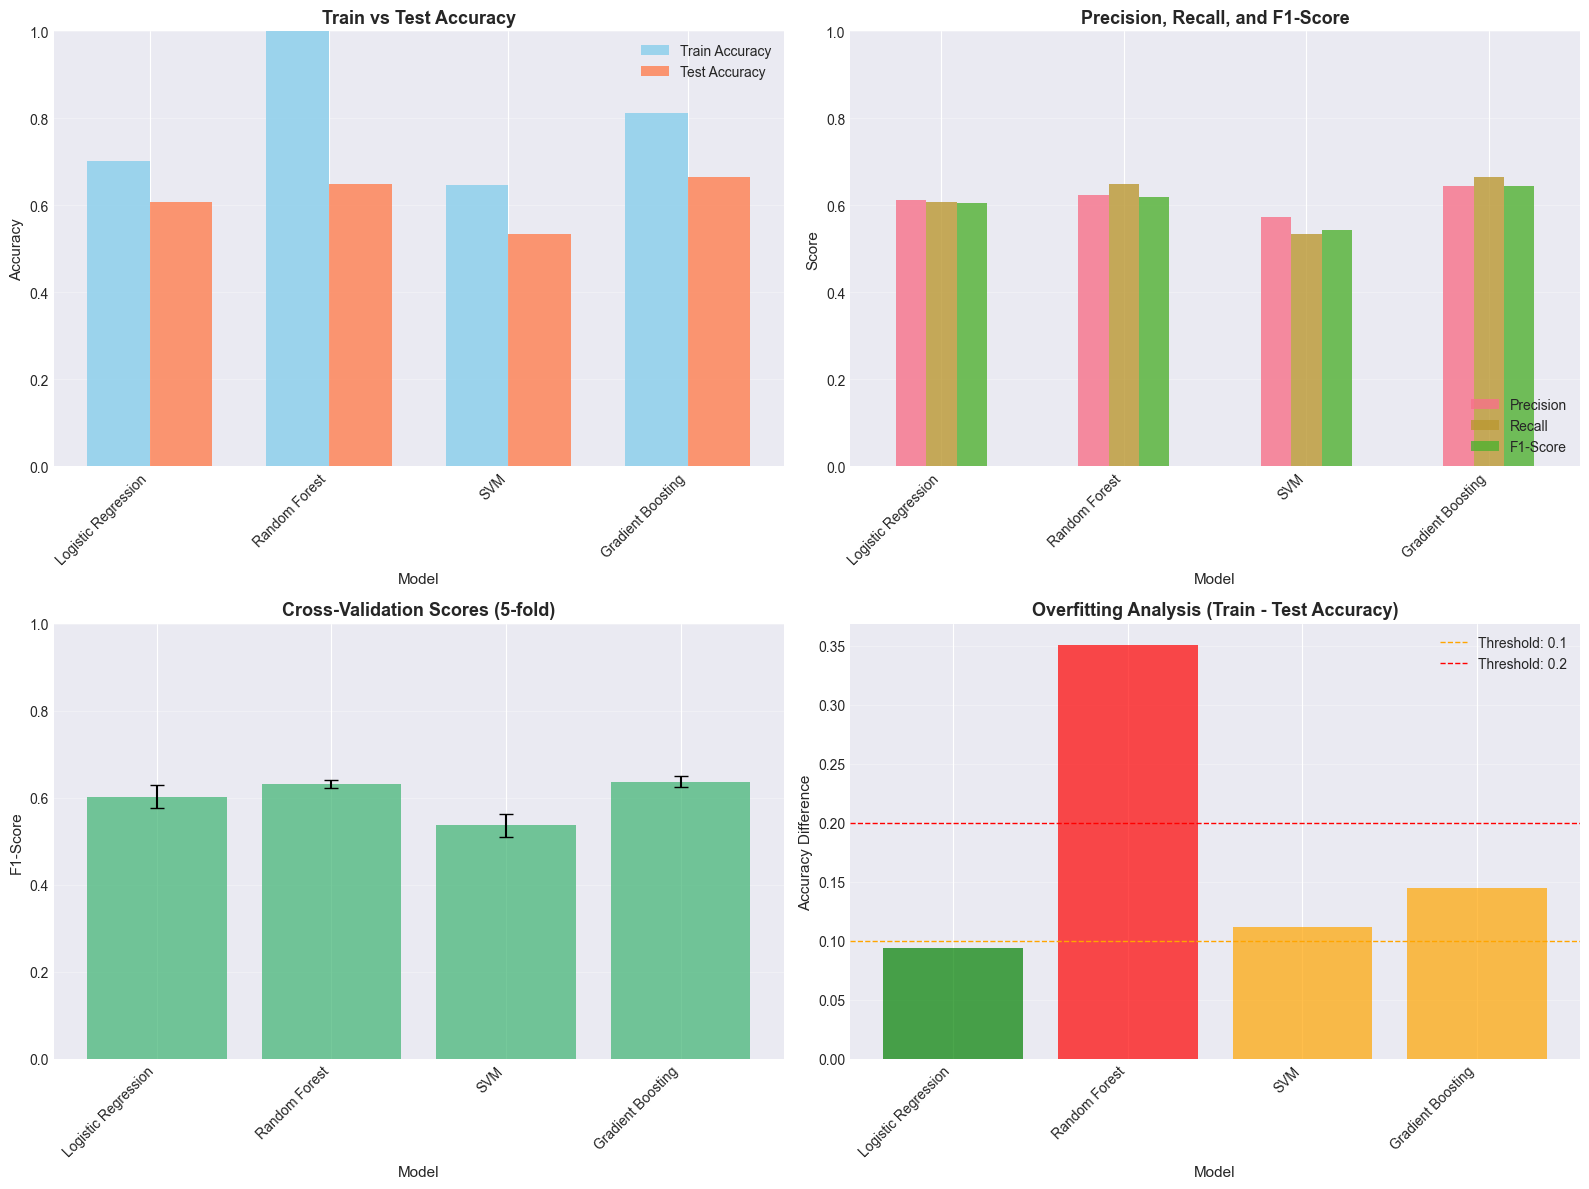

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(comparison_df))
width = 0.35
ax1.bar(x_pos - width/2, comparison_df['Train Acc'], width, 
        label='Train Accuracy', alpha=0.8, color='skyblue')
ax1.bar(x_pos + width/2, comparison_df['Test Acc'], width, 
        label='Test Accuracy', alpha=0.8, color='coral')
ax1.set_xlabel('Model', fontsize=11)
ax1.set_ylabel('Accuracy', fontsize=11)
ax1.set_title('Train vs Test Accuracy', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# 2. Precision, Recall, F1
ax2 = axes[0, 1]
metrics_to_plot = comparison_df.set_index('Model')[['Precision', 'Recall', 'F1-Score']]
metrics_to_plot.plot(kind='bar', ax=ax2, alpha=0.8)
ax2.set_title('Precision, Recall, and F1-Score', fontsize=13, fontweight='bold')
ax2.set_ylabel('Score', fontsize=11)
ax2.set_xlabel('Model', fontsize=11)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.legend(loc='lower right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1])

# 3. Cross-validation scores with error bars
ax3 = axes[1, 0]
ax3.bar(comparison_df['Model'], comparison_df['CV Mean'], 
        yerr=comparison_df['CV Std'], capsize=5, alpha=0.7, color='mediumseagreen')
ax3.set_title('Cross-Validation Scores (5-fold)', fontsize=13, fontweight='bold')
ax3.set_ylabel('F1-Score', fontsize=11)
ax3.set_xlabel('Model', fontsize=11)
ax3.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1])

# 4. Overfitting analysis
ax4 = axes[1, 1]
overfit = comparison_df['Train Acc'] - comparison_df['Test Acc']
colors = ['green' if x < 0.1 else 'orange' if x < 0.2 else 'red' for x in overfit]
ax4.bar(comparison_df['Model'], overfit, alpha=0.7, color=colors)
ax4.set_title('Overfitting Analysis (Train - Test Accuracy)', fontsize=13, fontweight='bold')
ax4.set_ylabel('Accuracy Difference', fontsize=11)
ax4.set_xlabel('Model', fontsize=11)
ax4.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax4.axhline(y=0.1, color='orange', linestyle='--', linewidth=1, label='Threshold: 0.1')
ax4.axhline(y=0.2, color='red', linestyle='--', linewidth=1, label='Threshold: 0.2')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

***Best Model Selection***

In [13]:
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"  Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")
print(f"  F1-Score:      {results[best_model_name]['f1']:.4f}")
print(f"  CV Score:      {results[best_model_name]['cv_mean']:.4f}")


Best Model: Gradient Boosting
  Test Accuracy: 0.6660
  F1-Score:      0.6444
  CV Score:      0.6374


***HyperParameter Tuning***

In [24]:
# Toggle this to turn tuning ON/OFF
DO_TUNING = True

# Defining parameter grids
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42, class_weight='balanced')
    
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5]
    }
    base_model = GradientBoostingClassifier(random_state=42)
    
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf', 'poly']
    }
    base_model = SVC(random_state=42, probability=True, class_weight='balanced')
    
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    }
    base_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    
else:
    param_grid = {}
    base_model = best_model


# ===========================
# Hyperparameter Tuning Block
# ===========================
if DO_TUNING and param_grid:
    print(f"\nHyperparameter tuning enabled.")
    print(f"Parameter grid: {param_grid}")
    
    grid_search = GridSearchCV(
        base_model, 
        param_grid, 
        cv=5, 
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    print("\nFitting Grid Search...")
    grid_search.fit(X_train, y_train)
    
    print("\n✓ Grid Search complete!")
    print("\nBest parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\nBest CV score: {grid_search.best_score_:.4f}")
    
    final_model = grid_search.best_estimator_
    
else:
    print("\nHyperparameter tuning skipped. Training base model...")
    final_model = base_model
    final_model.fit(X_train, y_train)



Hyperparameter tuning enabled.
Parameter grid: {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 5]}

Fitting Grid Search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

✓ Grid Search complete!

Best parameters:
  learning_rate: 0.1
  max_depth: 3
  min_samples_split: 2
  n_estimators: 300

Best CV score: 0.6424


***Final Model Evaluation***

In [25]:
# ===========================
# Evaluation
# ===========================
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nModel: {best_model_name}")
print(f"\nAccuracy:")
print(f"  Training:   {train_accuracy:.4f}")
print(f"  Test:       {test_accuracy:.4f}")
print(f"  Difference: {train_accuracy - test_accuracy:.4f}")


Model: Gradient Boosting

Accuracy:
  Training:   0.9380
  Test:       0.6630
  Difference: 0.2750


***Classification Report***

In [26]:
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)

report = classification_report(y_test, y_pred_test, target_names=class_names, digits=4)
print("\n" + report)

# Per-class metrics
print("\nPer-Class Performance:")
for idx, class_name in enumerate(class_names):
    mask = (y_test == idx)
    class_pred = y_pred_test[mask]
    class_true = y_test[mask]
    
    if len(class_true) > 0:
        class_acc = accuracy_score(class_true, class_pred)
        print(f"  {class_name}: {class_acc:.4f} ({len(class_true)} samples)")


DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

        easy     0.7048    0.5909    0.6429       198
        hard     0.7186    0.8680    0.7863       515
      medium     0.4670    0.3449    0.3968       287

    accuracy                         0.6630      1000
   macro avg     0.6301    0.6013    0.6086      1000
weighted avg     0.6437    0.6630    0.6461      1000


Per-Class Performance:
  easy: 0.5909 (198 samples)
  hard: 0.8680 (515 samples)
  medium: 0.3449 (287 samples)


In [27]:
print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)

cm = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix (raw counts):")
print(cm)


CONFUSION MATRIX

Confusion Matrix (raw counts):
[[117  28  53]
 [  8 447  60]
 [ 41 147  99]]


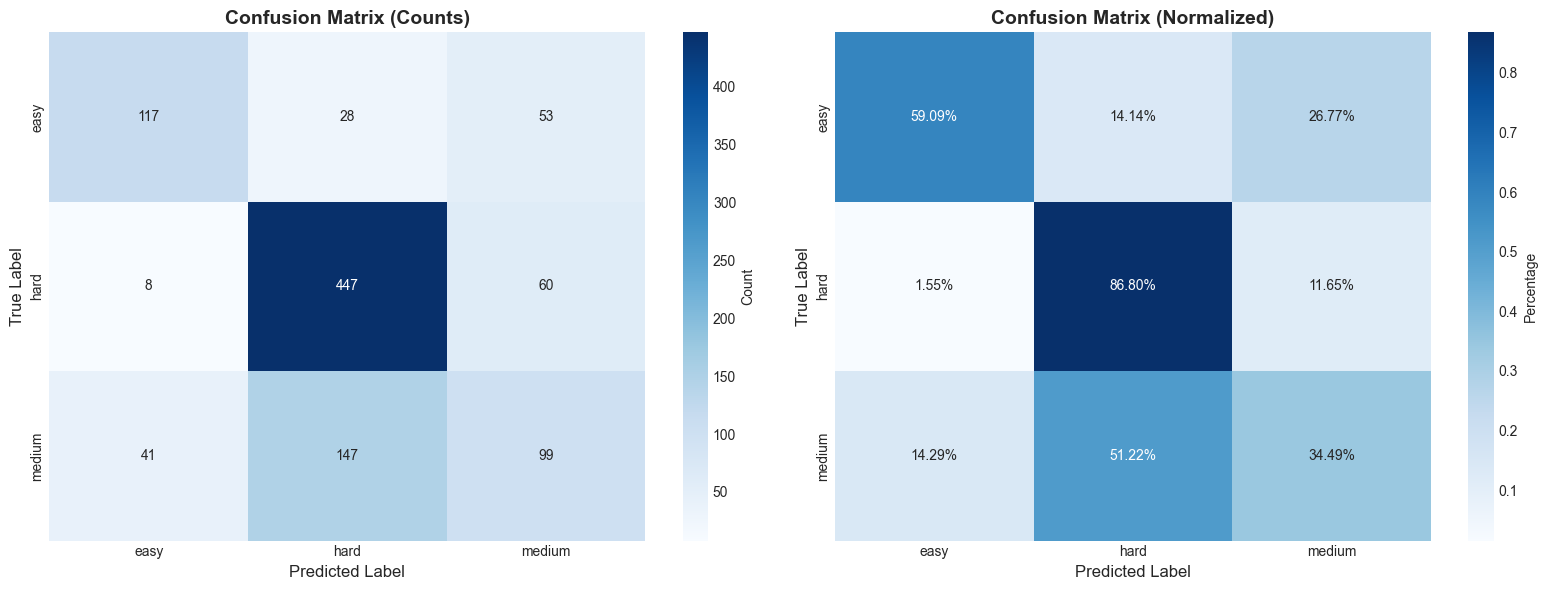

In [28]:
# Visualizing confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

In [29]:
print("\nPer-Class Error Analysis:")
for idx, class_name in enumerate(class_names):
    true_count = cm[idx].sum()
    correct = cm[idx, idx]
    accuracy = correct / true_count if true_count > 0 else 0
    error_rate = 1 - accuracy
    print(f"  {class_name}:")
    print(f"    Correct: {correct}/{true_count} ({accuracy:.2%})")
    print(f"    Error Rate: {error_rate:.2%}")


Per-Class Error Analysis:
  easy:
    Correct: 117/198 (59.09%)
    Error Rate: 40.91%
  hard:
    Correct: 447/515 (86.80%)
    Error Rate: 13.20%
  medium:
    Correct: 99/287 (34.49%)
    Error Rate: 65.51%


In [30]:
if hasattr(final_model, 'feature_importances_'):
    print("\n" + "="*70)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*70)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 most important features:")
    print(feature_importance.head(20).to_string(index=False))


FEATURE IMPORTANCE ANALYSIS

Top 20 most important features:
          feature  importance
   implementation    0.081912
               dp    0.066219
   graph_keywords    0.063560
       structures    0.045982
       test cases    0.029632
           exceed    0.029446
            lines    0.025707
           modulo    0.013459
          special    0.013360
    bracket_count    0.013207
        test case    0.010948
         integers    0.010034
           graphs    0.009518
             case    0.008766
    binary search    0.008518
math_symbol_count    0.008447
       char_count    0.008323
           le 100    0.008314
       word_count    0.008289
  avg_word_length    0.007970


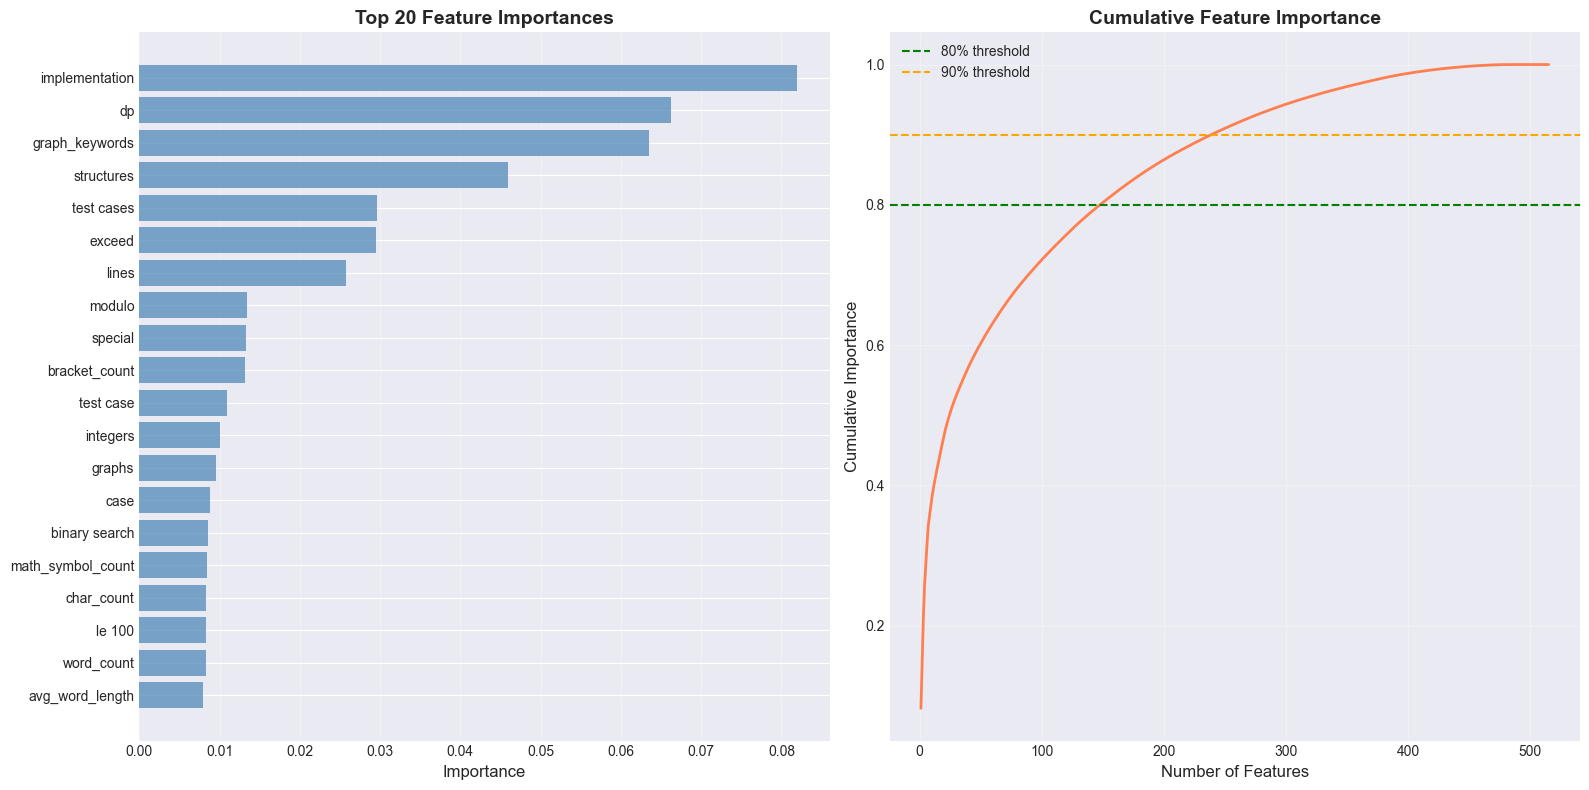

In [31]:
# Visualizing top features
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 20 features
top_20 = feature_importance.head(20)
axes[0].barh(range(len(top_20)), top_20['importance'], color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['feature'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Cumulative importance
feature_importance_sorted = feature_importance.sort_values('importance', ascending=False)
cumulative_importance = np.cumsum(feature_importance_sorted['importance'])

axes[1].plot(range(1, len(cumulative_importance) + 1), cumulative_importance,
             linewidth=2, color='coral')
axes[1].axhline(y=0.8, color='green', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Features', fontsize=12)
axes[1].set_ylabel('Cumulative Importance', fontsize=12)
axes[1].set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

***Saving Model and Results***

In [32]:
# Saving the final classification model
with open(r"D:\AutoJudge_v2\models\classification_model.pkl", 'wb') as f:
    pickle.dump(final_model, f)
print("✓ Saved: classification_model.pkl")

# Saving classification report as dictionary
report_dict = classification_report(y_test, y_pred_test, 
                                   target_names=class_names, 
                                   output_dict=True)

# Saving comprehensive results
classification_results = {
    'model_name': best_model_name,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'classification_report': report_dict,
    'confusion_matrix': cm.tolist(),
    'class_names': class_names.tolist(),
    'hyperparameters': final_model.get_params() if hasattr(final_model, 'get_params') else None,
    'feature_count': X.shape[1]
}

with open(r"D:\AutoJudge_v2\models\classification_results.pkl", 'wb') as f:
    pickle.dump(classification_results, f)
print("✓ Saved: classification_results.pkl")

✓ Saved: classification_model.pkl
✓ Saved: classification_results.pkl


***Summary Report***

In [33]:
print("\n" + "="*70)
print("CLASSIFICATION MODEL TRAINING - SUMMARY REPORT")
print("="*70)

print(f"""
Model Information:
  - Best Model: {best_model_name}
  - Number of Features: {X.shape[1]}
  - Training Samples: {len(X_train)}
  - Test Samples: {len(X_test)}

Performance Metrics:
  - Training Accuracy: {train_accuracy:.4f}
  - Test Accuracy: {test_accuracy:.4f}
  - Test Precision (weighted): {precision_score(y_test, y_pred_test, average='weighted'):.4f}
  - Test Recall (weighted): {recall_score(y_test, y_pred_test, average='weighted'):.4f}
  - Test F1-Score (weighted): {f1_score(y_test, y_pred_test, average='weighted'):.4f}

Per-Class Accuracy:
""")

for idx, class_name in enumerate(class_names):
    mask = (y_test == idx)
    if mask.sum() > 0:
        class_acc = accuracy_score(y_test[mask], y_pred_test[mask])
        print(f"  {class_name}: {class_acc:.4f}")

print(f"""
Model Comparison (Test F1-Score):
""")
for name, res in sorted(results.items(), key=lambda x: x[1]['f1'], reverse=True):
    print(f"  {name}: {res['f1']:.4f}")

print("\n" + "="*70)
print("CLASSIFICATION MODEL TRAINING COMPLETE! 🎉")
print("="*70)


CLASSIFICATION MODEL TRAINING - SUMMARY REPORT

Model Information:
  - Best Model: Gradient Boosting
  - Number of Features: 515
  - Training Samples: 3999
  - Test Samples: 1000

Performance Metrics:
  - Training Accuracy: 0.9380
  - Test Accuracy: 0.6630
  - Test Precision (weighted): 0.6437
  - Test Recall (weighted): 0.6630
  - Test F1-Score (weighted): 0.6461

Per-Class Accuracy:

  easy: 0.5909
  hard: 0.8680
  medium: 0.3449

Model Comparison (Test F1-Score):

  Gradient Boosting: 0.6444
  Random Forest: 0.6193
  Logistic Regression: 0.6054
  SVM: 0.5428

CLASSIFICATION MODEL TRAINING COMPLETE! 🎉
